# Libraries

In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from random import uniform
import plotly.graph_objects as go
import plotly.io as pio
import wandb
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
from torchviz import make_dot
from datetime import datetime

num_lessons = 10
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M%p")
π = pi
pio.renderers.default = 'notebook'
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
style.use(['dark_background', 'bmh'])
%matplotlib notebook

/var/folders/v4/yrd75qc17mg4cnlp5kqz6zcw0000gn/T/ipykernel_6621/3631861505.py:14: MatplotlibDeprecationWarning: MatplotlibDeprecationWarning was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  from matplotlib.cbook import MatplotlibDeprecationWarning


![car-trailer](figures/truck-backer-upper.png)


\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}

# Preparing Lessons

In [2]:
def create_lesson_configs(num_lessons):
    configs = {}

    first_lesson = {"θ0_range": (0, 10),
                    "Δθ1_range": (-10, 10),
                    "x_range": (10, 10),
                    "y_range": (-2, 2)}
    
    final_lesson = {"θ0_range": (0, 120),
                    "Δθ1_range": (-45, 45),
                    "x_range": (10, 35),
                    "y_range": (-7, 7)}

    x_min = first_lesson["x_range"][0]

    for i in range(1, num_lessons + 1):

        θ0_max = first_lesson["θ0_range"][1] + (final_lesson["θ0_range"][1] - 
                                                first_lesson["θ0_range"][1]) * (i - 1) // (num_lessons - 1)
        
        Δθ1_max = first_lesson["Δθ1_range"][1] + (final_lesson["Δθ1_range"][1] - 
                                                  first_lesson["Δθ1_range"][1]) * (i - 1) // (num_lessons - 1)
        
        x_max = first_lesson["x_range"][1] + (final_lesson["x_range"][1] - 
                                              first_lesson["x_range"][1]) * (i - 1) // (num_lessons - 1)
        
        y_max = first_lesson["y_range"][1] + (final_lesson["y_range"][1] - 
                                              first_lesson["y_range"][1]) * (i - 1) // (num_lessons - 1)

        configs[i] = {"θ0_range": (0, θ0_max),
                      "Δθ1_range": (-Δθ1_max, Δθ1_max),
                      "x_range": (x_min, x_max),
                      "y_range": (-y_max, y_max)}
        x_min = x_max
        
    configs[num_lessons+1] = final_lesson
    return configs

LESSON_CONFIGS = create_lesson_configs(num_lessons)

# Initializing Truck

In [3]:
class Truck:
    def __init__(self, lesson, display=False):

        self.W = 1 
        self.L = 1 * self.W 
        self.d = 4 * self.L 
        self.s = -0.1  
        self.display = display
        self.lesson = lesson
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(6, 3), num='The Truck Backer-Upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([]); self.ax.set_yticks([])
            self.ax.axhline(); self.ax.axvline()
            
    def reset(self, ϕ=0):
        self.ϕ = ϕ 
        config = LESSON_CONFIGS.get(self.lesson)
        
        if config is None: 
            raise ValueError(f"No configuration found for lesson {self.lesson}")       
            
        self.θ0 = deg2rad(uniform(*config["θ0_range"]))
        self.θ1 = deg2rad(uniform(*config["Δθ1_range"])) + self.θ0
        self.x = uniform(*config["x_range"])
        self.y = uniform(*config["y_range"])      
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: 
            self.draw()        
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt   
                        
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _trailer_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        angle_diff_rad = abs(θ0 - θ1)
        angle_diff_deg = rad2deg(angle_diff_rad)
        return angle_diff_deg > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._trailer_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()

        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=1)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=1, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, rad2deg(θ0)) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()    
        ax = self.ax
             
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=1, transform =
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, rad2deg(θ1)) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]
        
    def update_state(self, state): 
        self.ϕ, self.x, self.y, self.θ0, _, _, self.θ1 = state.tolist()

# Defining Functions to Train Emulator and Controller

In [4]:
def generate_random_deg(mean, std, scale_lower, scale_upper): 
    random_num = np.random.normal(loc = mean, scale = std)
    random_num_scaled = np.clip(random_num, scale_lower, scale_upper)
    return random_num_scaled

In [5]:
def initialize_emulator(): 
    emulator = nn.Sequential(
        nn.Linear(7, 100),
        nn.GELU(),
        nn.Linear(100, 100),
        nn.GELU(),
        nn.Linear(100, 6)
    )

    torch.save(emulator, 'models/emulators/emulator_lesson_0.pth')
    return emulator


def initialize_controller():
    controller = nn.Sequential( 
        nn.Linear(7, 50),
        nn.Tanh(),
        nn.Linear(50, 1)
    )
          
    torch.save(controller, 'models/controllers/controller_lesson_0.pth')
    return controller

In [6]:
criterion_emulator = nn.MSELoss()  

def criterion_controller(ϕ_state, step):
    _, _, _, θ0, x, y, θ1 = ϕ_state 
    angle_diff_rad = torch.abs(θ1 - θ0)
    angle_diff_deg = torch.rad2deg(angle_diff_rad)
    angle_diff_relu = nn.functional.relu((angle_diff_deg - 30)/30)
    x_relu = nn.functional.relu(x)
    min_θ1 = torch.min(torch.abs(θ1), torch.abs(torch.abs(θ1) - torch.deg2rad(torch.tensor(360.0))))
    part1 = x_relu + torch.abs(y) + min_θ1
    part2 = (x_relu**2 + y**2 + min_θ1**2 + angle_diff_relu**2 + step * 0.01)
    return -torch.log(1 / (part1 * part2))

In [7]:
def train_emulator(emulator, 
                   episodes, 
                   learning_rate, 
                   lesson, 
                   wandb_log = False):
    
    if wandb_log:
        wandb.init(project='emulator-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
        
    inputs = list()
    outputs = list()
    truck = Truck(lesson)
    for episode in tqdm(range(episodes)):
        truck.reset()
        while truck.valid():
            initial_state = truck.state()
            random_deg = generate_random_deg(mean = 0, 
                                             std = 35, 
                                             scale_lower = -70, 
                                             scale_upper = 70)
            ϕ = deg2rad(random_deg)
            inputs.append((ϕ, *initial_state))
            outputs.append(truck.step(ϕ))
            
    tensor_inputs = torch.Tensor(inputs)
    tensor_outputs = torch.Tensor(outputs)
    
    test_size = int(len(tensor_inputs) * 0.8)
    
    train_inputs = tensor_inputs[:test_size]
    train_outputs = tensor_outputs[:test_size]
    
    test_inputs = tensor_inputs[test_size:]
    test_outputs = tensor_outputs[test_size:]
    
    print("Train Size:", len(train_inputs))
    print("Test Size:", len(test_inputs))
    
    optimizer = torch.optim.Adam(emulator.parameters(), lr=learning_rate)
    
    global_step = 0
    for i in torch.randperm(len(train_inputs)):
        ϕ_state = train_inputs[i]
        
        next_state_prediction = emulator(ϕ_state)
        next_state = train_outputs[i]
        
        optimizer.zero_grad()
        
        loss = criterion_emulator(next_state_prediction, next_state)
        loss.backward()
        
        if wandb_log:
            wandb.log({'train_loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in emulator.named_parameters() if param.grad is not None}}, step=global_step)
        
        optimizer.step()
        global_step += 1

    with torch.no_grad():
        total_loss = 0
        for j in range(len(test_inputs)):
            ϕ_state = test_inputs[j]
            next_state = test_outputs[j]
            
            next_state_prediction = emulator(ϕ_state)
            
            loss = criterion_emulator(next_state_prediction, next_state)
            total_loss += loss.item()
            
            if wandb_log:
                wandb.log({'test_loss': loss.item()}, step = global_step)
                
            global_step += 1

    test_size = len(test_inputs)
    avg_test_loss = total_loss / test_size
    
    print()
    print(f'Test loss: {avg_test_loss:.10f}')
    
    torch.save(emulator, f'models/emulators/emulator_lesson_{lesson}.pth')
    
    if wandb_log:
        wandb.finish()
    
    return emulator

In [8]:
def train_controller(lesson, 
                     controller, 
                     epochs, 
                     max_steps,
                     wandb_log = False,
                     save_computational_graph = False,
                     learning_rate = 0.0001):
      
    if wandb_log: 
        wandb.init(project='controller-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
      
    emulator = torch.load('models/emulators/emulator_lesson_{}.pth'.format(lesson), weights_only=False)
    optimizer = torch.optim.Adam(controller.parameters(), lr=learning_rate, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    truck = Truck(lesson, display=False)
    
    for i in tqdm(range(epochs)):
        truck.reset()
        random_deg = generate_random_deg(mean = 0, 
                                         std = 70, 
                                         scale_lower = -70, 
                                         scale_upper = 70)
        ϕ = deg2rad(random_deg)
        state = truck.state()
        ϕ_state = torch.cat((torch.tensor([ϕ], dtype=torch.float32), 
                             torch.tensor(state, dtype=torch.float32))) 
        step = torch.tensor(0.0)
        
        while step <= max_steps and truck.valid():
            ϕ_prediction = controller(ϕ_state)
            next_state_prediction = emulator(ϕ_state)
            ϕ_state = torch.cat((ϕ_prediction, next_state_prediction))
            truck.update_state(ϕ_state)
            step += 1
        
        optimizer.zero_grad()
        loss = criterion_controller(ϕ_state, step)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(parameters = controller.parameters(),               
                                       max_norm = 1, 
                                       error_if_nonfinite = True)        
        
        if wandb_log:
            wandb.log({'loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in controller.named_parameters() if param.grad is not None}}, step=i)

        
        if save_computational_graph and i == 0 and lesson == 1: 
            dot = make_dot(loss, params=dict(controller.named_parameters()))
            dot.format = 'png'
            dot.render('computational-graphs/controller_computational_graph')
        
        optimizer.step()
        scheduler.step()
        
        if i % 100 == 0:
            torch.save(controller, 'models/controllers/controller_lesson_{}.pth'.format(lesson))
            loss_value = loss.item()
            print(f'{loss_value:.10f}')
    
    if wandb_log:
        wandb.finish()
            
    return controller

# Training Emulators

In [9]:
!rm -r models/emulators
!mkdir models/emulators

In [10]:
emulator = initialize_emulator()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    emulator = train_emulator(lesson = lesson,
                              emulator = emulator, 
                              episodes = 10_000,
                              learning_rate = 0.00001)
    print()

 Lesson 1:


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 934.88it/s]


Train Size: 512283
Test Size: 128071

Test loss: 0.0003104712

 Lesson 2:


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 892.03it/s]


Train Size: 556455
Test Size: 139114

Test loss: 0.0003117172

 Lesson 3:


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 813.57it/s]


Train Size: 610116
Test Size: 152529

Test loss: 0.0001782809

 Lesson 4:


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 793.56it/s]


Train Size: 617266
Test Size: 154317

Test loss: 0.0001499343

 Lesson 5:


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 856.94it/s]


Train Size: 587661
Test Size: 146916

Test loss: 0.0001505527

 Lesson 6:


100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 871.98it/s]


Train Size: 566728
Test Size: 141682

Test loss: 0.0002209881

 Lesson 7:


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 924.75it/s]


Train Size: 533597
Test Size: 133400

Test loss: 0.0001424523

 Lesson 8:


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 951.68it/s]


Train Size: 507425
Test Size: 126857

Test loss: 0.0001385444

 Lesson 9:


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1049.04it/s]


Train Size: 472823
Test Size: 118206

Test loss: 0.0002466074

 Lesson 10:


100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1138.20it/s]


Train Size: 442325
Test Size: 110582

Test loss: 0.0001775543

 Lesson 11:


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1096.79it/s]


Train Size: 451093
Test Size: 112774

Test loss: 0.0001582910



 # Training Controllers

In [11]:
!rm -rf models/controllers
!mkdir models/controllers

In [12]:
controller = initialize_controller()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    controller = train_controller(lesson = lesson, 
                                  controller = controller, 
                                  epochs = 3000,
                                  max_steps = 400)
    print()

 Lesson 1:


  0%|                                                  | 0/3000 [00:00<?, ?it/s]

5.0562877655


  4%|█▌                                      | 113/3000 [00:01<00:37, 78.01it/s]

2.4743862152


  7%|██▊                                     | 214/3000 [00:02<00:40, 69.41it/s]

3.0198242664


 11%|████▏                                   | 316/3000 [00:04<00:35, 75.41it/s]

3.0281717777


 14%|█████▌                                  | 414/3000 [00:05<00:34, 74.21it/s]

2.5019590855


 17%|██████▊                                 | 511/3000 [00:06<00:32, 77.35it/s]

1.8523361683


 20%|████████▏                               | 611/3000 [00:08<00:29, 80.07it/s]

0.3466370702


 24%|█████████▍                              | 711/3000 [00:09<00:29, 77.30it/s]

-0.9925630689


 27%|██████████▊                             | 810/3000 [00:10<00:28, 77.96it/s]

3.2282958031


 30%|████████████▏                           | 914/3000 [00:12<00:27, 74.95it/s]

2.0263047218


 34%|█████████████                          | 1009/3000 [00:13<00:26, 74.54it/s]

1.3354228735


 37%|██████████████▍                        | 1110/3000 [00:14<00:24, 77.01it/s]

-1.1798530817


 40%|███████████████▋                       | 1211/3000 [00:15<00:22, 78.62it/s]

0.2927203774


 44%|█████████████████                      | 1310/3000 [00:17<00:20, 81.49it/s]

-1.8992778063


 47%|██████████████████▎                    | 1409/3000 [00:18<00:19, 81.56it/s]

1.1419589520


 51%|███████████████████▋                   | 1517/3000 [00:19<00:17, 82.72it/s]

-2.8405566216


 54%|█████████████████████                  | 1616/3000 [00:20<00:17, 80.51it/s]

0.1786063015


 57%|██████████████████████▎                | 1714/3000 [00:22<00:16, 77.47it/s]

1.6420860291


 60%|███████████████████████▌               | 1815/3000 [00:23<00:14, 80.05it/s]

-1.7451831102


 64%|████████████████████████▉              | 1914/3000 [00:24<00:13, 81.61it/s]

1.8709260225


 67%|██████████████████████████▏            | 2012/3000 [00:25<00:12, 81.50it/s]

2.0470933914


 70%|███████████████████████████▍           | 2111/3000 [00:26<00:10, 81.57it/s]

-0.1797293127


 74%|████████████████████████████▋          | 2210/3000 [00:28<00:09, 81.85it/s]

-0.9768279195


 77%|██████████████████████████████         | 2309/3000 [00:29<00:08, 80.62it/s]

1.6988128424


 81%|███████████████████████████████▍       | 2417/3000 [00:30<00:07, 82.98it/s]

0.0621129014


 84%|████████████████████████████████▋      | 2510/3000 [00:31<00:06, 79.67it/s]

0.8492017388


 87%|█████████████████████████████████▉     | 2609/3000 [00:33<00:05, 74.78it/s]

0.0459635705


 90%|███████████████████████████████████▏   | 2709/3000 [00:34<00:03, 78.51it/s]

-1.6801342964


 94%|████████████████████████████████████▌  | 2811/3000 [00:35<00:02, 74.15it/s]

-0.5411517024


 97%|█████████████████████████████████████▉ | 2915/3000 [00:37<00:01, 72.79it/s]

0.4903275669


100%|███████████████████████████████████████| 3000/3000 [00:38<00:00, 78.14it/s]



 Lesson 2:


  0%|                                          | 5/3000 [00:00<01:42, 29.11it/s]

6.4126472473


  4%|█▍                                      | 109/3000 [00:02<00:49, 58.19it/s]

0.1888314486


  7%|██▋                                     | 205/3000 [00:03<01:00, 46.09it/s]

0.4368452132


 10%|████▏                                   | 310/3000 [00:05<00:46, 58.01it/s]

-0.4845378995


 14%|█████▍                                  | 409/3000 [00:07<00:45, 57.46it/s]

0.8232285976


 17%|██████▋                                 | 506/3000 [00:09<00:49, 50.75it/s]

6.7700462341


 20%|████████                                | 609/3000 [00:11<00:42, 56.06it/s]

-0.2521273196


 24%|█████████▍                              | 709/3000 [00:12<00:37, 60.63it/s]

-0.7302714586


 27%|██████████▋                             | 805/3000 [00:14<00:35, 61.11it/s]

2.8179531097


 30%|████████████                            | 905/3000 [00:16<00:36, 58.08it/s]

-1.7901456356


 34%|█████████████▏                         | 1013/3000 [00:17<00:32, 61.99it/s]

1.5843189955


 37%|██████████████▍                        | 1112/3000 [00:19<00:31, 59.89it/s]

-0.2901543677


 40%|███████████████▋                       | 1209/3000 [00:21<00:29, 60.07it/s]

-0.2692322731


 44%|████████████████▉                      | 1307/3000 [00:22<00:30, 55.49it/s]

-0.1629383862


 47%|██████████████████▎                    | 1407/3000 [00:24<00:30, 52.77it/s]

-0.7347108722


 50%|███████████████████▌                   | 1508/3000 [00:26<00:24, 59.92it/s]

-2.2886352539


 54%|████████████████████▉                  | 1607/3000 [00:27<00:21, 64.08it/s]

-1.6830983162


 57%|██████████████████████▏                | 1707/3000 [00:29<00:20, 62.10it/s]

-0.9471153021


 60%|███████████████████████▌               | 1812/3000 [00:31<00:19, 61.94it/s]

-0.7827417850


 64%|████████████████████████▊              | 1909/3000 [00:32<00:17, 61.60it/s]

-0.6838687658


 67%|██████████████████████████             | 2009/3000 [00:34<00:15, 62.20it/s]

-2.6693763733


 70%|███████████████████████████▍           | 2113/3000 [00:36<00:14, 60.51it/s]

-0.4762504697


 74%|████████████████████████████▋          | 2211/3000 [00:37<00:13, 60.46it/s]

2.0102052689


 77%|██████████████████████████████         | 2310/3000 [00:39<00:11, 62.12it/s]

-1.7669572830


 80%|███████████████████████████████▎       | 2410/3000 [00:41<00:09, 60.56it/s]

-2.4545910358


 84%|████████████████████████████████▌      | 2506/3000 [00:42<00:08, 59.74it/s]

-0.8586742878


 87%|█████████████████████████████████▉     | 2615/3000 [00:44<00:05, 66.14it/s]

-2.3107359409


 90%|███████████████████████████████████▏   | 2709/3000 [00:45<00:04, 65.24it/s]

-1.6266239882


 94%|████████████████████████████████████▍  | 2807/3000 [00:47<00:02, 68.26it/s]

0.0843521282


 97%|█████████████████████████████████████▊ | 2910/3000 [00:48<00:01, 67.45it/s]

-0.3988267779


100%|███████████████████████████████████████| 3000/3000 [00:50<00:00, 59.70it/s]



 Lesson 3:


  0%|                                          | 6/3000 [00:00<01:01, 48.48it/s]

1.6324900389


  4%|█▍                                      | 108/3000 [00:02<00:52, 55.25it/s]

-0.6473845243


  7%|██▊                                     | 208/3000 [00:03<00:48, 57.39it/s]

6.6970009804


 10%|████▏                                   | 310/3000 [00:05<00:46, 58.44it/s]

-0.1375970244


 14%|█████▍                                  | 409/3000 [00:07<00:48, 53.13it/s]

-0.9097872376


 17%|██████▊                                 | 510/3000 [00:09<00:47, 52.60it/s]

-0.7075413465


 20%|████████                                | 608/3000 [00:11<00:41, 57.50it/s]

-0.1534819603


 24%|█████████▍                              | 712/3000 [00:13<00:43, 52.63it/s]

0.2371007204


 27%|██████████▋                             | 805/3000 [00:15<00:42, 51.32it/s]

-0.9400199056


 30%|████████████                            | 906/3000 [00:17<00:45, 46.53it/s]

-1.2914336920


 34%|█████████████▏                         | 1010/3000 [00:19<00:41, 47.68it/s]

-1.4623465538


 37%|██████████████▍                        | 1107/3000 [00:21<00:38, 49.05it/s]

-0.3396600783


 40%|███████████████▋                       | 1205/3000 [00:23<00:40, 44.22it/s]

0.5923147798


 44%|████████████████▉                      | 1306/3000 [00:25<00:36, 46.51it/s]

-1.1525573730


 47%|██████████████████▎                    | 1409/3000 [00:27<00:34, 46.37it/s]

-1.1807904243


 50%|███████████████████▌                   | 1508/3000 [00:29<00:33, 44.95it/s]

-0.9425747395


 54%|████████████████████▉                  | 1609/3000 [00:31<00:28, 48.28it/s]

-0.8107504845


 57%|██████████████████████▏                | 1710/3000 [00:34<00:27, 46.09it/s]

0.0985426828


 60%|███████████████████████▌               | 1810/3000 [00:36<00:23, 49.92it/s]

6.7249307632


 64%|████████████████████████▊              | 1909/3000 [00:38<00:23, 45.98it/s]

-1.3149901628


 67%|██████████████████████████▏            | 2011/3000 [00:40<00:19, 49.95it/s]

-0.3701495230


 70%|███████████████████████████▍           | 2111/3000 [00:42<00:17, 49.68it/s]

-2.1039893627


 74%|████████████████████████████▋          | 2206/3000 [00:44<00:17, 46.25it/s]

-1.1324419975


 77%|██████████████████████████████         | 2308/3000 [00:46<00:14, 48.77it/s]

-2.8158638477


 80%|███████████████████████████████▎       | 2407/3000 [00:48<00:12, 48.83it/s]

0.5022233129


 84%|████████████████████████████████▌      | 2507/3000 [00:50<00:10, 45.65it/s]

-0.7333405614


 87%|█████████████████████████████████▊     | 2605/3000 [00:52<00:08, 44.98it/s]

0.7579705715


 90%|███████████████████████████████████▏   | 2707/3000 [00:55<00:06, 47.34it/s]

-2.0338959694


 94%|████████████████████████████████████▍  | 2807/3000 [00:57<00:03, 52.24it/s]

-1.4082539082


 97%|█████████████████████████████████████▊ | 2905/3000 [00:59<00:02, 44.81it/s]

-1.1573401690


100%|███████████████████████████████████████| 3000/3000 [01:01<00:00, 48.92it/s]



 Lesson 4:


  0%|                                          | 5/3000 [00:00<01:03, 47.12it/s]

-0.1659529507


  3%|█▍                                      | 104/3000 [00:02<01:27, 33.22it/s]

-0.4948548973


  7%|██▊                                     | 208/3000 [00:05<01:14, 37.44it/s]

8.2160005569


 10%|████                                    | 306/3000 [00:08<01:15, 35.58it/s]

-1.3743047714


 14%|█████▍                                  | 405/3000 [00:11<01:12, 35.89it/s]

-1.1044342518


 17%|██████▋                                 | 505/3000 [00:14<01:13, 34.05it/s]

-0.7649416924


 20%|████████                                | 607/3000 [00:17<01:05, 36.32it/s]

-1.5516978502


 23%|█████████▍                              | 704/3000 [00:20<01:09, 32.87it/s]

-1.3602142334


 27%|██████████▋                             | 805/3000 [00:23<01:06, 32.81it/s]

-2.0262918472


 30%|████████████                            | 907/3000 [00:26<00:59, 35.11it/s]

-1.1119401455


 34%|█████████████                          | 1007/3000 [00:29<00:58, 34.04it/s]

-2.3584318161


 37%|██████████████▍                        | 1106/3000 [00:31<00:50, 37.76it/s]

-1.0955547094


 40%|███████████████▋                       | 1208/3000 [00:34<00:50, 35.80it/s]

1.0475724936


 44%|████████████████▉                      | 1307/3000 [00:37<00:45, 36.94it/s]

-0.2982281744


 47%|██████████████████▎                    | 1405/3000 [00:40<00:47, 33.67it/s]

-2.5549011230


 50%|███████████████████▌                   | 1506/3000 [00:43<00:42, 35.26it/s]

-2.9952452183


 54%|████████████████████▊                  | 1605/3000 [00:45<00:39, 35.54it/s]

-1.5611697435


 57%|██████████████████████▏                | 1705/3000 [00:48<00:37, 34.71it/s]

-1.6089090109


 60%|███████████████████████▌               | 1808/3000 [00:51<00:32, 37.01it/s]

-2.3714165688


 64%|████████████████████████▊              | 1907/3000 [00:54<00:29, 36.81it/s]

-1.8588244915


 67%|██████████████████████████             | 2004/3000 [00:57<00:26, 36.92it/s]

-2.7392702103


 70%|███████████████████████████▍           | 2107/3000 [00:59<00:24, 36.38it/s]

-2.8123917580


 74%|████████████████████████████▋          | 2207/3000 [01:02<00:20, 38.57it/s]

-3.2413263321


 77%|█████████████████████████████▉         | 2306/3000 [01:05<00:18, 36.72it/s]

-2.9973247051


 80%|███████████████████████████████▎       | 2405/3000 [01:07<00:15, 38.70it/s]

-1.7678368092


 84%|████████████████████████████████▌      | 2507/3000 [01:10<00:13, 36.99it/s]

-2.1419212818


 87%|█████████████████████████████████▊     | 2605/3000 [01:13<00:10, 36.58it/s]

-3.0556056499


 90%|███████████████████████████████████▏   | 2706/3000 [01:15<00:08, 36.71it/s]

-1.7950853109


 93%|████████████████████████████████████▍  | 2804/3000 [01:18<00:05, 35.32it/s]

-2.4188671112


 97%|█████████████████████████████████████▊ | 2907/3000 [01:21<00:02, 37.67it/s]

-1.2889754772


100%|███████████████████████████████████████| 3000/3000 [01:23<00:00, 35.77it/s]



 Lesson 5:


  0%|                                          | 4/3000 [00:00<01:25, 35.22it/s]

0.5893847942


  3%|█▎                                      | 103/3000 [00:02<01:06, 43.86it/s]

-1.8025907278


  7%|██▋                                     | 204/3000 [00:05<01:23, 33.37it/s]

-2.4871058464


 10%|████                                    | 307/3000 [00:08<01:21, 32.90it/s]

-2.5273516178


 14%|█████▍                                  | 405/3000 [00:11<01:13, 35.49it/s]

-3.0401210785


 17%|██████▋                                 | 505/3000 [00:14<01:09, 35.77it/s]

8.4760808945


 20%|████████                                | 607/3000 [00:17<01:06, 35.85it/s]

-2.1341965199


 23%|█████████▎                              | 703/3000 [00:20<01:11, 32.11it/s]

-2.0804295540


 27%|██████████▋                             | 805/3000 [00:23<01:02, 35.22it/s]

9.1117610931


 30%|████████████                            | 904/3000 [00:26<01:06, 31.48it/s]

-1.6862270832


 34%|█████████████                          | 1005/3000 [00:29<00:59, 33.59it/s]

-2.2636911869


 37%|██████████████▎                        | 1104/3000 [00:32<01:02, 30.52it/s]

-0.6818763614


 40%|███████████████▋                       | 1207/3000 [00:35<00:57, 31.13it/s]

-1.9424148798


 44%|████████████████▉                      | 1305/3000 [00:38<00:55, 30.72it/s]

-2.4004166126


 47%|██████████████████▎                    | 1407/3000 [00:41<00:43, 36.77it/s]

-2.0303776264


 50%|███████████████████▌                   | 1509/3000 [00:44<00:39, 37.94it/s]

-2.6444516182


 54%|████████████████████▊                  | 1605/3000 [00:47<00:41, 33.22it/s]

-2.1203441620


 57%|██████████████████████▏                | 1706/3000 [00:50<00:35, 36.14it/s]

-2.2939999104


 60%|███████████████████████▍               | 1805/3000 [00:53<00:36, 32.57it/s]

-2.8832945824


 64%|████████████████████████▊              | 1905/3000 [00:56<00:34, 32.09it/s]

-2.6495122910


 67%|██████████████████████████             | 2003/3000 [00:59<00:30, 32.78it/s]

-2.2927842140


 70%|███████████████████████████▍           | 2107/3000 [01:02<00:23, 37.64it/s]

-2.8940913677


 74%|████████████████████████████▋          | 2206/3000 [01:05<00:24, 32.33it/s]

-1.6549032927


 77%|█████████████████████████████▉         | 2304/3000 [01:08<00:20, 33.75it/s]

-2.4222710133


 80%|███████████████████████████████▎       | 2405/3000 [01:11<00:18, 32.79it/s]

-1.7132072449


 84%|████████████████████████████████▌      | 2509/3000 [01:14<00:12, 38.52it/s]

8.6378192902


 87%|█████████████████████████████████▊     | 2605/3000 [01:16<00:12, 32.34it/s]

-4.5806550980


 90%|███████████████████████████████████▏   | 2705/3000 [01:20<00:09, 32.14it/s]

-3.1563093662


 94%|████████████████████████████████████▌  | 2808/3000 [01:23<00:05, 35.70it/s]

-2.7068426609


 97%|█████████████████████████████████████▊ | 2904/3000 [01:26<00:02, 33.03it/s]

-3.6901803017


100%|███████████████████████████████████████| 3000/3000 [01:29<00:00, 33.55it/s]



 Lesson 6:


  0%|                                          | 4/3000 [00:00<01:22, 36.16it/s]

9.1512289047


  3%|█▎                                      | 103/3000 [00:03<01:44, 27.76it/s]

9.7000303268


  7%|██▋                                     | 205/3000 [00:07<01:37, 28.64it/s]

9.5307407379


 10%|████                                    | 303/3000 [00:11<01:28, 30.50it/s]

-3.7144861221


 13%|█████▍                                  | 404/3000 [00:14<01:10, 36.62it/s]

9.5939579010


 17%|██████▋                                 | 504/3000 [00:17<01:14, 33.38it/s]

-2.2187988758


 20%|████████                                | 606/3000 [00:20<01:10, 33.78it/s]

-2.9175906181


 24%|█████████▍                              | 706/3000 [00:23<01:15, 30.35it/s]

-3.2692451477


 27%|██████████▋                             | 805/3000 [00:26<01:00, 36.14it/s]

-3.0421895981


 30%|████████████                            | 906/3000 [00:29<01:06, 31.26it/s]

-2.3603959084


 34%|█████████████                          | 1007/3000 [00:32<01:03, 31.52it/s]

-3.2449600697


 37%|██████████████▍                        | 1106/3000 [00:35<00:49, 37.91it/s]

-3.7826151848


 40%|███████████████▋                       | 1203/3000 [00:37<00:40, 44.43it/s]

9.3760156631


 43%|████████████████▉                      | 1304/3000 [00:40<00:55, 30.67it/s]

-1.8739762306


 47%|██████████████████▎                    | 1407/3000 [00:43<00:47, 33.52it/s]

-3.2565119267


 50%|███████████████████▌                   | 1504/3000 [00:46<00:44, 33.85it/s]

-3.6082525253


 54%|████████████████████▉                  | 1608/3000 [00:48<00:33, 42.11it/s]

9.2918767929


 57%|██████████████████████▏                | 1708/3000 [00:51<00:33, 38.43it/s]

-2.5491979122


 60%|███████████████████████▍               | 1803/3000 [00:54<00:35, 33.67it/s]

-3.9985144138


 63%|████████████████████████▊              | 1904/3000 [00:57<00:32, 33.25it/s]

-3.5834641457


 67%|██████████████████████████             | 2005/3000 [01:00<00:28, 34.84it/s]

-2.1021616459


 70%|███████████████████████████▎           | 2103/3000 [01:03<00:24, 37.25it/s]

-3.3919973373


 74%|████████████████████████████▋          | 2208/3000 [01:06<00:23, 34.31it/s]

-1.8910000324


 77%|█████████████████████████████▉         | 2304/3000 [01:09<00:21, 32.30it/s]

-3.7520446777


 80%|███████████████████████████████▎       | 2405/3000 [01:12<00:17, 34.92it/s]

-2.8653228283


 84%|████████████████████████████████▌      | 2507/3000 [01:15<00:14, 33.79it/s]

9.6451244354


 87%|█████████████████████████████████▉     | 2608/3000 [01:17<00:10, 36.79it/s]

-2.8923525810


 90%|███████████████████████████████████▏   | 2702/3000 [01:20<00:07, 39.06it/s]

9.5568523407


 94%|████████████████████████████████████▍  | 2806/3000 [01:23<00:05, 33.04it/s]

-2.0620186329


 97%|█████████████████████████████████████▊ | 2904/3000 [01:26<00:02, 42.80it/s]

9.4436035156


100%|███████████████████████████████████████| 3000/3000 [01:29<00:00, 33.51it/s]



 Lesson 7:


  0%|                                          | 4/3000 [00:00<01:36, 31.07it/s]

10.1392011642


  4%|█▍                                      | 106/3000 [00:03<01:11, 40.57it/s]

9.9103069305


  7%|██▊                                     | 209/3000 [00:06<01:14, 37.69it/s]

9.7757368088


 10%|████                                    | 308/3000 [00:09<01:17, 34.75it/s]

-1.8527611494


 14%|█████▍                                  | 410/3000 [00:12<01:01, 42.20it/s]

9.7836713791


 17%|██████▋                                 | 503/3000 [00:14<01:08, 36.26it/s]

9.7475252151


 20%|████████                                | 603/3000 [00:17<01:00, 39.87it/s]

9.4792032242


 23%|█████████▎                              | 703/3000 [00:20<00:46, 49.45it/s]

-2.1581931114


 27%|██████████▋                             | 805/3000 [00:22<00:56, 38.64it/s]

9.7328395844


 30%|████████████                            | 906/3000 [00:25<00:54, 38.40it/s]

-4.5049872398


 34%|█████████████                          | 1007/3000 [00:28<00:45, 44.04it/s]

9.7979173660


 37%|██████████████▎                        | 1104/3000 [00:30<00:40, 46.96it/s]

-2.5741827488


 40%|███████████████▋                       | 1204/3000 [00:33<00:52, 34.37it/s]

9.6060771942


 44%|█████████████████                      | 1310/3000 [00:36<00:47, 35.62it/s]

-5.3008799553


 47%|██████████████████▎                    | 1408/3000 [00:38<00:38, 41.43it/s]

-3.9977524281


 50%|███████████████████▌                   | 1508/3000 [00:41<00:45, 32.68it/s]

-3.1200459003


 54%|████████████████████▉                  | 1606/3000 [00:44<00:30, 46.46it/s]

-1.4671511650


 57%|██████████████████████▏                | 1708/3000 [00:46<00:34, 37.12it/s]

-3.4680519104


 60%|███████████████████████▌               | 1808/3000 [00:49<00:30, 39.47it/s]

-3.4937107563


 63%|████████████████████████▋              | 1903/3000 [00:51<00:26, 40.96it/s]

-3.8737127781


 67%|██████████████████████████             | 2006/3000 [00:53<00:29, 33.78it/s]

-3.3932135105


 70%|███████████████████████████▎           | 2104/3000 [00:56<00:27, 32.83it/s]

9.6700706482


 74%|████████████████████████████▋          | 2210/3000 [00:59<00:15, 49.70it/s]

9.4527845383


 77%|█████████████████████████████▉         | 2306/3000 [01:01<00:18, 36.85it/s]

9.6445064545


 80%|███████████████████████████████▎       | 2406/3000 [01:04<00:16, 35.74it/s]

-3.2718846798


 84%|████████████████████████████████▌      | 2505/3000 [01:06<00:15, 32.99it/s]

-4.3771047592


 87%|█████████████████████████████████▊     | 2602/3000 [01:09<00:08, 44.59it/s]

9.7234363556


 90%|███████████████████████████████████▏   | 2707/3000 [01:12<00:08, 33.43it/s]

9.0856904984


 94%|████████████████████████████████████▍  | 2805/3000 [01:15<00:05, 32.83it/s]

-2.2340285778


 97%|█████████████████████████████████████▊ | 2906/3000 [01:18<00:02, 41.20it/s]

-5.0464277267


100%|███████████████████████████████████████| 3000/3000 [01:20<00:00, 37.17it/s]



 Lesson 8:


  0%|                                          | 4/3000 [00:00<01:31, 32.75it/s]

-0.0840831399


  3%|█▍                                      | 104/3000 [00:02<01:02, 46.25it/s]

-1.8233981133


  7%|██▋                                     | 202/3000 [00:05<01:28, 31.62it/s]

-1.9929535389


 10%|████                                    | 303/3000 [00:08<01:21, 33.00it/s]

-2.0642733574


 14%|█████▌                                  | 413/3000 [00:10<00:47, 53.98it/s]

9.8426694870


 17%|██████▋                                 | 505/3000 [00:13<01:24, 29.68it/s]

10.0680084229


 20%|████████                                | 606/3000 [00:16<01:16, 31.19it/s]

-2.7234950066


 24%|█████████▍                              | 705/3000 [00:19<00:57, 40.11it/s]

10.6301813126


 27%|██████████▋                             | 804/3000 [00:21<00:58, 37.67it/s]

10.0031404495


 30%|████████████                            | 906/3000 [00:24<00:55, 37.82it/s]

10.1418190002


 34%|█████████████                          | 1008/3000 [00:27<00:42, 46.87it/s]

-3.6250016689


 37%|██████████████▍                        | 1106/3000 [00:29<00:58, 32.25it/s]

-1.4268602133


 40%|███████████████▋                       | 1205/3000 [00:32<00:52, 33.89it/s]

-3.6056585312


 43%|████████████████▉                      | 1303/3000 [00:35<00:42, 40.26it/s]

-2.8599865437


 47%|██████████████████▎                    | 1405/3000 [00:37<00:42, 37.57it/s]

-2.4529609680


 50%|███████████████████▌                   | 1502/3000 [00:40<00:27, 54.66it/s]

10.0732202530


 54%|████████████████████▉                  | 1606/3000 [00:42<00:36, 38.69it/s]

-3.1575834751


 57%|██████████████████████▏                | 1706/3000 [00:45<00:28, 44.70it/s]

9.9239234924


 60%|███████████████████████▍               | 1807/3000 [00:47<00:26, 44.92it/s]

10.1265125275


 64%|████████████████████████▊              | 1905/3000 [00:50<00:28, 38.26it/s]

-2.8807396889


 67%|██████████████████████████             | 2008/3000 [00:53<00:28, 35.43it/s]

-3.1018257141


 70%|███████████████████████████▎           | 2103/3000 [00:56<00:23, 38.10it/s]

-1.4963208437


 74%|████████████████████████████▋          | 2210/3000 [00:58<00:18, 43.23it/s]

10.0025014877


 77%|█████████████████████████████▉         | 2305/3000 [01:01<00:18, 38.49it/s]

-2.2618312836


 80%|███████████████████████████████▎       | 2407/3000 [01:03<00:16, 36.22it/s]

-2.0728363991


 84%|████████████████████████████████▌      | 2505/3000 [01:06<00:15, 31.98it/s]

-2.5720007420


 87%|█████████████████████████████████▉     | 2611/3000 [01:09<00:07, 53.36it/s]

-3.1784465313


 90%|███████████████████████████████████▏   | 2705/3000 [01:11<00:07, 37.75it/s]

-1.9837864637


 94%|████████████████████████████████████▍  | 2805/3000 [01:13<00:05, 34.93it/s]

-2.7838475704


 97%|█████████████████████████████████████▊ | 2904/3000 [01:17<00:02, 34.44it/s]

9.9516983032


100%|███████████████████████████████████████| 3000/3000 [01:20<00:00, 37.46it/s]



 Lesson 9:


  0%|                                          | 4/3000 [00:00<01:21, 36.76it/s]

10.2914152145


  4%|█▍                                      | 107/3000 [00:03<01:16, 37.71it/s]

-0.3930923641


  7%|██▋                                     | 203/3000 [00:06<01:07, 41.31it/s]

-0.4301006794


 10%|████                                    | 304/3000 [00:09<01:22, 32.83it/s]

10.3852758408


 13%|█████▍                                  | 404/3000 [00:11<00:53, 48.79it/s]

10.3049583435


 17%|██████▋                                 | 506/3000 [00:14<01:00, 40.95it/s]

10.4550189972


 20%|████████                                | 606/3000 [00:17<01:06, 35.89it/s]

-1.1035798788


 23%|█████████▎                              | 703/3000 [00:20<01:02, 36.70it/s]

-1.7069649696


 27%|██████████▊                             | 808/3000 [00:23<00:54, 40.41it/s]

-1.6938731670


 30%|████████████                            | 903/3000 [00:25<00:52, 40.27it/s]

10.4415149689


 34%|█████████████▏                         | 1011/3000 [00:27<00:44, 45.00it/s]

10.6572866440


 37%|██████████████▎                        | 1103/3000 [00:30<00:49, 38.26it/s]

10.4847345352


 40%|███████████████▋                       | 1208/3000 [00:33<00:45, 39.60it/s]

10.6748085022


 44%|█████████████████                      | 1311/3000 [00:35<00:39, 43.13it/s]

-1.9408519268


 47%|██████████████████▎                    | 1406/3000 [00:38<00:45, 35.20it/s]

10.3992099762


 50%|███████████████████▌                   | 1503/3000 [00:41<00:32, 45.85it/s]

10.4733629227


 54%|████████████████████▉                  | 1608/3000 [00:44<00:35, 39.63it/s]

-2.2776367664


 57%|██████████████████████▏                | 1709/3000 [00:46<00:26, 49.23it/s]

-2.9288434982


 60%|███████████████████████▍               | 1807/3000 [00:48<00:35, 33.72it/s]

-1.8730404377


 64%|████████████████████████▊              | 1911/3000 [00:51<00:27, 40.31it/s]

-3.3142468929


 67%|██████████████████████████▏            | 2011/3000 [00:54<00:17, 55.66it/s]

10.0996093750


 70%|███████████████████████████▍           | 2107/3000 [00:56<00:23, 37.41it/s]

-3.1818461418


 74%|████████████████████████████▋          | 2208/3000 [00:58<00:14, 55.67it/s]

10.4120492935


 77%|█████████████████████████████▉         | 2303/3000 [01:01<00:19, 35.86it/s]

10.3513507843


 80%|███████████████████████████████▎       | 2407/3000 [01:03<00:10, 55.78it/s]

10.5741968155


 84%|████████████████████████████████▌      | 2505/3000 [01:06<00:10, 45.37it/s]

10.6219959259


 87%|█████████████████████████████████▉     | 2606/3000 [01:09<00:10, 38.52it/s]

10.6251077652


 90%|███████████████████████████████████▏   | 2707/3000 [01:12<00:07, 41.18it/s]

-2.8509101868


 93%|████████████████████████████████████▍  | 2804/3000 [01:15<00:04, 48.73it/s]

10.3152933121


 97%|█████████████████████████████████████▊ | 2912/3000 [01:17<00:01, 51.90it/s]

-4.1153483391


100%|███████████████████████████████████████| 3000/3000 [01:20<00:00, 37.40it/s]



 Lesson 10:


  0%|                                          | 3/3000 [00:00<02:28, 20.14it/s]

10.6498832703


  3%|█▍                                      | 104/3000 [00:03<01:24, 34.27it/s]

11.1432085037


  7%|██▊                                     | 207/3000 [00:05<01:01, 45.36it/s]

-0.8119582534


 10%|████                                    | 304/3000 [00:08<01:10, 38.10it/s]

0.8746733665


 14%|█████▍                                  | 406/3000 [00:11<01:21, 31.76it/s]

0.5131348372


 17%|██████▋                                 | 503/3000 [00:13<01:04, 38.47it/s]

10.5899801254


 20%|████████                                | 603/3000 [00:16<01:18, 30.36it/s]

11.0471820831


 23%|█████████▍                              | 704/3000 [00:19<01:12, 31.87it/s]

10.9322547913


 27%|██████████▋                             | 801/3000 [00:21<00:54, 40.40it/s]

10.8233242035


 30%|████████████                            | 907/3000 [00:24<00:33, 62.07it/s]

10.5900821686


 34%|█████████████                          | 1005/3000 [00:27<00:54, 36.85it/s]

10.7807645798


 37%|██████████████▎                        | 1103/3000 [00:30<00:43, 43.74it/s]

-1.4680041075


 40%|███████████████▋                       | 1204/3000 [00:32<00:45, 39.70it/s]

10.7036170959


 43%|████████████████▉                      | 1302/3000 [00:35<00:48, 34.65it/s]

-0.3240392208


 47%|██████████████████▎                    | 1405/3000 [00:38<00:46, 34.65it/s]

-1.1891579628


 50%|███████████████████▋                   | 1510/3000 [00:40<00:34, 43.57it/s]

11.0334243774


 54%|████████████████████▉                  | 1607/3000 [00:44<00:39, 35.16it/s]

10.4948635101


 57%|██████████████████████▏                | 1705/3000 [00:46<00:32, 39.73it/s]

10.5276374817


 60%|███████████████████████▍               | 1807/3000 [00:49<00:32, 36.56it/s]

-1.4158866405


 64%|████████████████████████▊              | 1908/3000 [00:51<00:24, 44.49it/s]

10.5925626755


 67%|██████████████████████████             | 2001/3000 [00:54<00:22, 43.87it/s]

10.9704046249


 70%|███████████████████████████▎           | 2103/3000 [00:57<00:25, 34.92it/s]

10.8601102829


 73%|████████████████████████████▋          | 2204/3000 [01:00<00:29, 27.37it/s]

-1.6393996477


 77%|██████████████████████████████         | 2311/3000 [01:03<00:16, 42.29it/s]

10.9875459671


 80%|███████████████████████████████▎       | 2405/3000 [01:06<00:18, 31.84it/s]

10.9633884430


 84%|████████████████████████████████▌      | 2505/3000 [01:08<00:13, 36.60it/s]

-0.3347480893


 87%|█████████████████████████████████▉     | 2607/3000 [01:12<00:13, 29.26it/s]

-0.6130594015


 90%|███████████████████████████████████▏   | 2704/3000 [01:14<00:10, 28.82it/s]

-1.0520204306


 93%|████████████████████████████████████▍  | 2803/3000 [01:17<00:05, 35.73it/s]

10.9444246292


 97%|█████████████████████████████████████▊ | 2909/3000 [01:21<00:02, 31.74it/s]

10.8331985474


100%|███████████████████████████████████████| 3000/3000 [01:23<00:00, 35.86it/s]



 Lesson 11:


  0%|                                          | 3/3000 [00:00<01:42, 29.38it/s]

10.5638685226


  4%|█▌                                      | 114/3000 [00:01<00:37, 77.93it/s]

9.7626447678


  7%|██▊                                     | 209/3000 [00:03<00:44, 62.39it/s]

1.7814561129


 10%|████                                    | 308/3000 [00:05<00:38, 69.14it/s]

-0.1255637109


 14%|█████▌                                  | 417/3000 [00:07<00:40, 63.40it/s]

10.9152593613


 17%|██████▊                                 | 508/3000 [00:09<00:46, 53.35it/s]

8.6157016754


 20%|████████                                | 606/3000 [00:11<01:04, 37.08it/s]

-0.9364491105


 24%|█████████▍                              | 707/3000 [00:13<00:41, 54.81it/s]

-0.8486790657


 27%|██████████▋                             | 804/3000 [00:15<00:40, 53.90it/s]

0.5171011090


 30%|████████████▏                           | 912/3000 [00:17<00:34, 61.06it/s]

10.5589275360


 34%|█████████████                          | 1007/3000 [00:19<00:53, 37.19it/s]

0.3837973475


 37%|██████████████▍                        | 1111/3000 [00:22<00:46, 41.05it/s]

0.1789410710


 40%|███████████████▋                       | 1208/3000 [00:24<00:34, 51.82it/s]

8.9991188049


 44%|████████████████▉                      | 1305/3000 [00:26<00:34, 49.28it/s]

8.9010267258


 47%|██████████████████▎                    | 1407/3000 [00:28<00:37, 42.66it/s]

6.3237409592


 50%|███████████████████▌                   | 1506/3000 [00:30<00:36, 40.71it/s]

0.9031181335


 54%|████████████████████▉                  | 1613/3000 [00:32<00:21, 65.70it/s]

10.5628490448


 57%|██████████████████████▏                | 1707/3000 [00:34<00:21, 58.91it/s]

-0.8476595879


 60%|███████████████████████▌               | 1811/3000 [00:36<00:24, 48.46it/s]

0.2305314839


 64%|████████████████████████▊              | 1908/3000 [00:38<00:26, 41.65it/s]

-0.2812609673


 67%|██████████████████████████             | 2009/3000 [00:41<00:26, 37.90it/s]

-0.6726901531


 70%|███████████████████████████▍           | 2114/3000 [00:42<00:14, 59.95it/s]

0.3006589413


 74%|████████████████████████████▋          | 2207/3000 [00:44<00:13, 58.42it/s]

-1.0461080074


 77%|█████████████████████████████▉         | 2307/3000 [00:46<00:15, 43.32it/s]

0.7764314413


 80%|███████████████████████████████▎       | 2408/3000 [00:48<00:09, 61.67it/s]

-1.5405848026


 84%|████████████████████████████████▌      | 2507/3000 [00:49<00:10, 47.99it/s]

0.4747372270


 87%|█████████████████████████████████▊     | 2605/3000 [00:51<00:07, 55.58it/s]

9.7563409805


 90%|███████████████████████████████████▏   | 2707/3000 [00:53<00:06, 44.68it/s]

9.5274810791


 94%|████████████████████████████████████▌  | 2812/3000 [00:55<00:03, 61.63it/s]

-0.9059547782


 97%|█████████████████████████████████████▉ | 2916/3000 [00:57<00:01, 66.34it/s]

8.3750095367


100%|███████████████████████████████████████| 3000/3000 [00:59<00:00, 50.47it/s]

# Testing Results

<IPython.core.display.Javascript object>


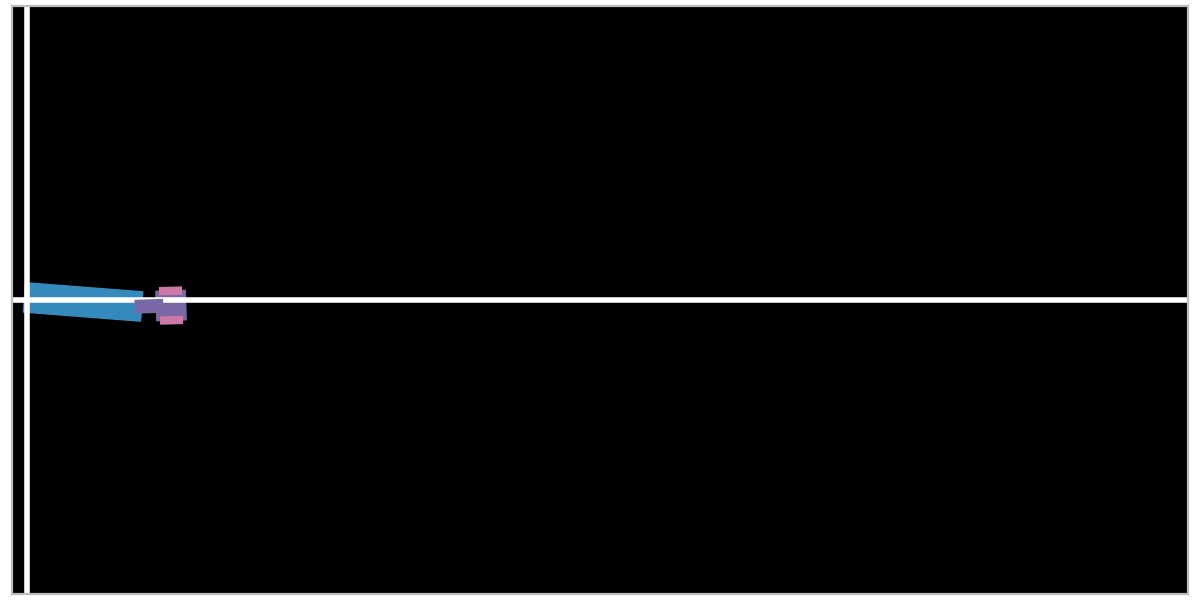

In [68]:
final_lesson = num_lessons + 1
test_controller = torch.load('models/controllers/controller_lesson_{}.pth'.format(final_lesson), weights_only = False)

truck = Truck(lesson = final_lesson, display = True)
truck.reset()

In [94]:
with torch.no_grad():
    truck.reset()
    i = 0
    while truck.valid():
        t1 = torch.tensor([truck.ϕ],dtype=torch.float32)
        state = truck.state()      
        t2 = torch.Tensor(state)
        state = torch.cat((t1,t2))
        ϕ = test_controller(state)
        truck.step(ϕ.item())
        truck.draw()
        i += 1
    print("Number of Steps: {}".format(i))

Number of Steps: 231
